# launch scripts through SLURM 

The script in the cell below submits SLURM jobs running the requested `script`, over all file names in `MOLECULES_DIR`. 

The generated SBATCH scipts (`.job` files) are saved in the `jobs` folder and then submitted.
Output and error dumps are saved in the `out` folder.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.abspath('../..'))
from convoQC.utils import MOLECULES_DIR, load_ucc_data, UCC_DIR

In [6]:
origin_files = list(sorted(f[:-5] for f in os.listdir(MOLECULES_DIR)))
print(*enumerate(origin_files), sep = '\n')

(0, 'H,0,0,0;H,0.401,0,0;H,-0.1196,0.9943,0;H,0.0526,0.2628,-0.3113')
(1, 'H,0,0,0;H,0.4023,0,0;H,0.3393,1.0607,0;H,-0.0812,-0.0573,-0.426')
(2, 'H,0,0,0;H,0.4028,0,0;H,-0.4404,0.4811,0;H,0.0828,-0.7849,-0.2394')
(3, 'H,0,0,0;H,0.4059,0,0;H,0.3759,1.4515,0;H,0.4392,1.1007,0.7042')
(4, 'H,0,0,0;H,0.4069,0,0;H,-0.3451,-0.2725,0;H,-1.0738,-0.6908,-0.3546')
(5, 'H,0,0,0;H,0.4114,0,0;H,-0.4279,0.0812,0;H,-0.0788,-0.356,-0.8135')
(6, 'H,0,0,0;H,0.4123,0,0;H,-0.4045,-0.6587,0;H,0.2841,-0.8592,0.7478')
(7, 'H,0,0,0;H,0.4126,0,0;H,-0.2106,0.649,0;H,0.8249,0.612,-0.0679')
(8, 'H,0,0,0;H,0.4133,0,0;H,-0.2724,-0.9518,0;H,-0.3922,0.0689,-0.3457')
(9, 'H,0,0,0;H,0.4146,0,0;H,0.9868,-0.25,0;H,0.9996,0.5175,0.5359')
(10, 'H,0,0,0;H,0.4169,0,0;H,-0.3849,0.1773,0;H,0.6302,0.261,-0.6179')
(11, 'H,0,0,0;H,0.4173,0,0;H,-0.3895,-0.5687,0;H,0.0402,0.7187,0.5656')
(12, 'H,0,0,0;H,0.4246,0,0;H,0.0455,1.0763,0;H,-0.8365,0.3432,0.1956')
(13, 'H,0,0,0;H,0.4253,0,0;H,-0.6681,0.0871,0;H,-0.2323,-0.3529,0.1775')
(14

In [4]:
#######################
### User parameters ###
#######################

script = 'optimize_ucc.py'
time = "00-15:00"  # format days-hh:mm
mem = "100MB"  # can use postfixes (MB, GB, ...)
partition = "compIntel"

additional_lines = [
    'source ~/.bashrc\n'
]


#####################################
### Create folders, files and run ###
#####################################

current_dir = os.path.abspath('.')
script = os.path.join(*os.path.split(current_dir)[:-1], 'scripts', script)
job_dir = 'jobs'
out_dir = 'out'

os.makedirs(job_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

for idx, filename in enumerate(origin_files):
    job_name = 'H4-UCC-{}'.format(idx)
    job_file = os.path.join(job_dir, job_name+'.job')
    
    with open(job_file, 'wt') as fh:
        fh.writelines(
            ["#!/bin/bash\n",
            f"#SBATCH --job-name={job_name}\n",
            f"#SBATCH --output={os.path.join(out_dir, job_name+'.out')}\n",
            f"#SBATCH --error={os.path.join(out_dir, job_name+'.err')}\n",
            f"#SBATCH --time={time}\n",
            f"#SBATCH --mem={mem}\n",
            f"#SBATCH --partition={partition}\n",
            f"#SBATCH --mail-type=NONE\n",
            ] + additional_lines + [
            f"python -u {script} '{filename}'\n"]
        )

    os.system("sbatch %s" %job_file)

# Load & analyse results 

In [15]:
ucc_files = os.listdir(UCC_DIR)
ucc_dataset = [load_ucc_data(f) for f in ucc_files]
overlaps_success = [d['infidelity'] for d in ucc_dataset if d['optimizer_success'] is True]
overlaps_failure = [d['infidelity'] for d in ucc_dataset if d['optimizer_success'] is False]

succeeded 492, failed 8


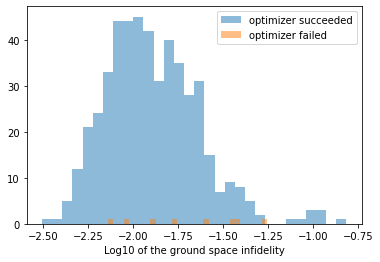

In [16]:
print(f'succeeded {len(overlaps_success)}, failed {len(overlaps_failure)}')
plt.hist(np.log10(overlaps_success), 30, alpha=.5, label='optimizer succeeded')
plt.hist(np.log10(overlaps_failure), 30, alpha=.5, label='optimizer failed')
plt.legend()
plt.xlabel('Log10 of the ground space infidelity')
plt.show()